In [1]:
import numpy
import math
#from multiprocessing.dummy import Pool as ThreadPool 
#pool = ThreadPool(4) 
import time
numpy.random.seed(int(time.time()))

# Introducao 
#### Quando comecei, fiquei bastante confuso com o dataset minst, entao fui implementando a rede neural por etapas. 
1. Primeiro fiz operacoes logicas/booleanas simples, NAND, XOR etc. As funcoes bool,bool -> bool foram bem simples e as bool,bool -> bool,bool tambem, nao vi muitas dificuldades.
2. a medida que fui me familiarizando, fui para funcoes lineares (y = ax+b) que trouxeram novos desafios, principalmente por terem variaveis float e dimensionalidades nao tao fixas (quando generalizamos para polinomiais como um todo) fiz a besteira de ir fazendo no mesmo arquivo uma por cima da outra, entao "perdi" meu trabalho ate entao, ficando apenas com o progresso acumulado. 
3. Esta primeira sessao foi logo apos de resolver sistema de equacao em termos de multiplicacao de matrizes. Como eu estava estimando matrizes de coeficientes, achei que seria interessante estimar a matriz de conversao XYZ -> RGB. Usei minhas funcoes do T1 para gerar 1000  valores que usei como dados de treinamento. 

#### Eu fui lendo bastante pela internet, um artigo que gostei bastante foi esse: https://medium.com/technology-invention-and-more/how-to-build-a-multi-layered-neural-network-in-python-53ec3d1d326a

In [2]:
def compand(v):
    v = abs(v)
    if v <= 0.0031308 :
        return v * 12.92
    else:
        return (v ** (1./2.4))*1.055-0.055

def sRGB(xyz,ilu=0):
    # Matriz de conversão XYZ -> RGB em D65. Retirada do site do Lindbloom.
    sRGBref_D65 = [[ 3.2404542, -1.5371385, -0.4985314],
           [ -0.9692660,  1.8760108,  0.0415560],
           [ 0.0556434, -0.2040259,  1.0572252]]
    # Matriz de conversão XYZ -> RGB em D50. Retirada do site do Lindbloom.
    sRGBref_D50 = [[ 3.1338561, -1.6168667, -0.4906146],
                   [-0.9787684,  1.9161415,  0.0334540],
                   [0.0719453, -0.2289914,  1.4052427]]
    sRGBref =[sRGBref_D65,sRGBref_D50]
    rgb = numpy.dot(sRGBref[ilu],xyz)
    rgb = [ compand(i) for i in rgb]
    return rgb

def sRGBclip(xyz,rgb=None,ilu=0):
    if rgb is None:
        rgb = sRGB(xyz,ilu)
    return [max(min(x, 1), 0) for x in rgb]

#sRGB([0,1,0])

In [3]:
a = numpy.arange(0,1,0.1)#0.1
b = numpy.arange(0,1,0.1)
c = numpy.arange(0,1,0.1)
nums = []
rgb_nums = []
for i in a:
    for j in b:
        for k in c:
            nums += [[i,j,k]]
            rgb_nums +=[sRGB([i,j,k])]

### Aqui comecamos a implementacao da rede, com definicao da arquitetura

In [4]:
Input = numpy.array(nums)
Output = numpy.array(rgb_nums).T
hidden = 4
layers = numpy.array([
        2 * numpy.random.random((len(Input[0]), hidden)) - 1, 
        2 * numpy.random.random((hidden, len(Output.T[0]))) - 1
])

N = 100
print(numpy.shape(Input))
print(numpy.shape(layers[0]))
print(numpy.shape(layers[1]))
print(numpy.shape(Output))
#Input

(1000, 3)
(3, 4)
(4, 3)
(3, 1000)


### Funcoes de ativacao

In [5]:
def sigmoid(x):
    return 1 / (1 + numpy.exp(-x))
def Dsigmoid(X):
    return numpy.array([x * (1 - x) for x in X])

### Essa celula foi onde eu trabalhei mais, contem a implementacao de fato (que mudou ligeiramente mais abaixo)

In [6]:
Input = numpy.array(nums)
Output = numpy.array(rgb_nums).T
hidden = 50
layers = numpy.array([
        2 * numpy.random.random((len(Input[0]), hidden)) - 1, 
        #2 * numpy.random.random((hidden, hidden)) - 1, 
        #2 * numpy.random.random((hidden, hidden)) - 1, 
        2 * numpy.random.random((hidden, len(Output.T[0]))) - 1
])

N = 10000



## feedforward
def question(X,layers):
    outs = []
    outs += [X]
    for i in range(1,len(layers)+1):
        outs += [sigmoid(numpy.dot(outs[i-1],layers[i-1]))]
    outs = outs[1:]
    return outs,layers

## evaluation
def evaluate(x,Y,layers):
    x.reverse()
    err = []
    lesson = []
    err += [Y.T - x[0]]
    lesson += [err[0]*Dsigmoid(x[0])]
    #print(numpy.shape(err[0]),numpy.shape(lesson[0]))
    for i in range(1,len(layers)):
        err += [numpy.dot(lesson[i-1],layers[len(layers)-i].T)]
        #print(numpy.shape(err[i]))
        lesson += [err[i]*Dsigmoid(x[i])]
        #print(numpy.shape(lesson[i]))
    err.reverse()
    lesson.reverse()    
    return err,lesson,layers

## backpropagation
def memorize(inp,errors,lessons,ans,layers):
    #print(np.shape(ans[i]))
    #print(lessons)
    notes = []
    #print(numpy.shape(inp.T))
    #print(numpy.shape(lessons[0]))
    notes +=[numpy.dot(inp.T,lessons[0])]
    for g in range(0,len(layers)-1):
        #print(g)
        #print(numpy.shape(ans[g].T))
        #print(numpy.shape(lessons[g+1]))
        notes += [numpy.dot(ans[g+1].T,lessons[g+1])]
    #print()
    #[print(numpy.shape(a)) for a in notes]
    #print()
    #[print(numpy.shape(a)) for a in layers]
    for k in range(0,len(layers)-1):
        #x = numpy.dot(ans[k-1].T, notes[k])
        #print(numpy.shape(x))
        #print(numpy.shape(layers[k]))
        layers[k] = layers[k] + notes[k]
    return layers
#print(question([1,0,0])[1])        

## treinamento
for i in range(0,N):
    if i%(N/10) == 0 and i!=0:
        print(i,N,ME)
    answers,layers = question(Input,layers)
    #[print(numpy.shape(a)) for a in answers]
    #print()
    errors,lessons,layers = evaluate(answers,Output,layers)
    layers = memorize(Input,errors,lessons,answers,layers)
    ME = numpy.mean([numpy.mean(abs(i)) for i in errors])
    if ME < 0.045:
        print('finished by error rate',ME)
        break
    #[print(numpy.shape(a)) for a in errors]
    #[print(numpy.shape(a)) for a in lessons]
    #print()
    #print(errors)
    
    #print(errors)
    if i == N-1:
        print('finished by iterations')
  
#print(layers[1])
#print(question([1,0,0]))


1000 10000 0.05976266444656971
2000 10000 0.04978545313874139
3000 10000 0.048442361929378425
4000 10000 0.047780758662552894
5000 10000 0.047008977070968024
6000 10000 0.04670046528838069
7000 10000 0.046540001577095966
8000 10000 0.0464090298637198
9000 10000 0.04630950497778451
finished by iterations


In [7]:
#question([0,0,0])

In [7]:
import matplotlib.pyplot as plt
import pandas


### Fiz uma tabela comparativa para ir vendo o progresso (passei cerca de 50% do trabalho neste ponto, indo e voltando e corrigindo)

In [8]:
inputs = numpy.random.random((50,3))
inputs = Input
#print(inputs)
ret = [question(v,layers)[0][-1] for v in inputs]
dados = { 
            'XYZ': ['X: %f Y:%f Z:%f'% tuple(v) for v in inputs],
            'RGB': ['R: %f G:%f B:%f'% tuple(sRGB(v)) for v in inputs],
            'corRGB':["#%2x%2x%2x"%(tuple([int(255*i) for i in sRGBclip(v)])) for v in inputs],
            'NN': ['R: %f G:%f B:%f'% tuple(v) for v in ret],
            'corNN':["#%2x%2x%2x"%(tuple([int(255*i) for i in v])) for v in ret],
            'erro': [numpy.linalg.norm(ret[k]-sRGB(inputs[k])) for k in range(0,len(inputs))]
        }
tabela = pandas.DataFrame(data=dados)
tabela = tabela[['XYZ','RGB','corRGB','NN','corNN','erro']]

def style(v):
    return 'background-color: '+ v
styled = tabela.style.applymap(style,
                  subset=pandas.IndexSlice[['corRGB','corNN']])
styled 

### Quando me dei por satisfeito com os valores e erros, resolvi testar com uma imagem para ver o resultado, mais por curiosidade do que por algum conteudo de fato

In [9]:
from PIL import Image
from matplotlib.pyplot import imshow

img = Image.open('dog.jpg')

rgb2xyz = (
    0.412453, 0.357580, 0.180423, 0,
    0.212671, 0.715160, 0.072169, 0,
    0.019334, 0.119193, 0.950227, 0 )
imgxyz = img.convert("RGB", rgb2xyz)
imgxyz_o = imgxyz.copy()
pixels = imgxyz.load()
#tuple(question(numpy.array(pixels[0,0])/255.0)[-1])
for i in range(img.size[0]):    # for every col:
    for j in range(img.size[1]):    # For every row
        #print(pixels[i,j])
        xyz = question(numpy.array(pixels[i,j])/255.0,layers)[0][-1]
        xyz = [math.floor(a*255.0) for a in xyz]
        pixels[i,j] = tuple(xyz)
        #pixels[i,j] = question(pixels[i,j])[-1]


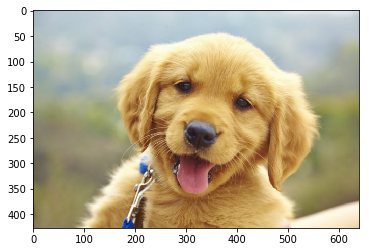

In [10]:
%matplotlib inline
imshow(numpy.asarray(img))

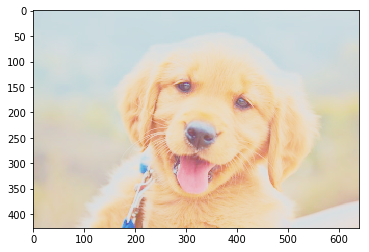

In [11]:
%matplotlib inline
imshow(numpy.asarray(imgxyz))

### Nao fiquei muito impressionado, mas acho que talvez seja mais culpa das minhas conversoes do que da rede em si. Vou revisitar isso depois.

### A funcao abaixo eu peguei na internet para ler o mnist, achei que nao ia acrescentar muito fazer isso na mao...

In [12]:
import os
import struct
import numpy as np

"""
Loosely inspired by http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
which is GPL licensed.
"""

def read(dataset = "training", path = "."):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    #else:
        #raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()


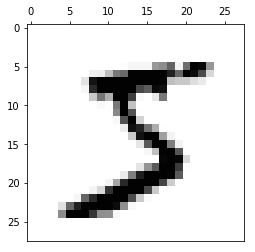

In [13]:
train = list(read('training'))
test = list(read('testing'))
label,pixels = train[0]
show(pixels)

## Aqui ficou minha implementacao final, mais limpa e um pouquinho mais otimizada. Utilizando import cupy as np para rodar na placa, com CUDA, ficou razoavel (alguns segundos vs alguns minutos)

In [14]:
import time
def create_train(input_data,output_data,size_hidden,num_hidden,iterations,errorOK=0):
    numpy.random.seed(int(time.time()))
    Input = numpy.array(input_data)
    Output = numpy.array(output_data).T
    hidden = size_hidden
    ls = num_hidden*[2 * numpy.random.random((hidden, hidden)) - 1]
    ls.insert(0,     2 * numpy.random.random((len(Input[0]), hidden)) - 1)
    ls.insert(num_hidden+1,    2 * numpy.random.random((hidden, len(Output.T[0]))) - 1)
    print(numpy.shape(Input))
    for l in ls:
        print(numpy.shape(l))
    print(numpy.shape(Output))
    #ls = numpy.array(ls)
    N = iterations
    threshold = 0.001
    for i in range(0,N): 
        if i%(N/100) == 0 and i!=0:
            print(i,N,ME)
        answers,ls = question(Input,ls)
        #print(answers)
        errors,lessons,ls = evaluate(answers,Output,ls)
        ME_ = numpy.mean([numpy.mean(abs(i)) for i in errors])
        if ME_< errorOK:
            print('exit by error found')
            break
        #else:
        #    if 'ME' in locals() and abs(ME-ME_) < threshold:
        #        print('exit by stability')
        #        break
        ME = ME_
        ls = memorize(Input,errors,lessons,answers,ls)
    return lambda x: question(x,ls)


In [16]:
size = int(len(train)/60)
outputs = [0]*size
inputs = [0]*size
for t in range(0,size):
    outputs[t] = [train[t][0]]
    inputs[t] = train[t][1].flatten()
print(np.shape(outputs))
print(np.shape(inputs))
#inputs

(1000, 1)
(1000, 784)


1. testei diversas combinacoes de numero de camadas, tamanho, numero de iteracoes... Gostaria de fazer graficos comparando tempo, memoria, resultado por cada um destas dimensoes. 
2. A unica dimensao monotona foi iteracoes. O resto diminuia ou aumentava erro dependendo dos numeros e combinacoes, nao consegui inferir muito o porque. 
3. Comecei com tamanho da camada escondida = 784 (28*28) mais por logica e numero de camadas = 2 por recomendacao do enunciado. Nao foi mais efetivo que tamanhos menores de camada. Ainda sim, aumentava o tempo/memoria quase que em n3. 
4. Testei bastante com fatias do conjunto de treinamento, ate ficar confortavel. Quando treino com os 60k, o maior tempo eh em carregar na memoria tudo.


In [17]:
f = create_train(inputs,outputs,784,2,4)

(1000, 784)
(784, 784)
(784, 784)
(784, 784)
(784, 1)
(1, 1000)


/home/leo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


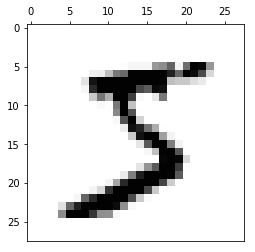

/home/leo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


array([1.])

In [18]:
show(inputs[0].reshape(28,28))
f(inputs[0])[0][-1]

### Com muito tempo de processamento (e memoria), atingi no maximo 0.79 de erro. Isso eh mto abaixo dos scores que encontro por ai. Apesar disso fiquei satisfeito com o desempenho da rede no final. Pretendo implementar novas otimizacoes (como SGD e minibatch) mas acredito que o resultado esta apresentado.